In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
from dsp.Runner import SequenceSolver
from dsp.Problem import Problem
from dsp.Solver import DPSolver
from dtspx_ampl import ampl_solve
import pandas as pd
import pprint as pp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from multiprocessing import Pool
import pickle

In [3]:
# Time frame
T = 6

# Data
x_data = np.genfromtxt("data/x.csv", delimiter=",")
y_data = np.genfromtxt("data/y.csv", delimiter=",")

xy_data = np.stack([x_data, y_data], axis=2)

# Create sequence solver object
P = Problem(xy_data, T=T)
root = DPSolver(P, seq=[])

ALPHA = set(P.in_working_area)
np.random.seed(10)



In [4]:
PF = {
    '4' : np.array([0, 41.1, 42.8, 43.4, 46.6, 47.3, 48.7, 50.5, 53.8, 60.0, 70.1, 80.8, 90.1, 100.6, 115.0, 128.2]), 
    '6' : np.array([0, 29.6, 41.3, 42.9, 43.5, 46.6, 47.3, 48.7, 50.5, 53.8, 55.4, 60.5, 70.6, 81.4, 89.5, 99.5, 110.6, 124.4, 176.2, 190.4, 209.8]),
    '8' : np.array([0, 29.6, 41.3, 42.9, 43.5, 46.2, 47.3, 48.7, 50.3, 51.0, 52.5, 55.8, 57.3, 61.9, 67.2, 76.8, 81.5, 86.7, 94.4, 107.2, 112.8, 122.2, 133.2, 147.1, 159.4, 173.3])    
}

In [5]:
SeqSolver = SequenceSolver(problem=P, root=root, height_limit=5)

In [18]:
res = SeqSolver.sequence_search(available=ALPHA, 
                                truncation_args={
                                    'limit' : 1000,
                                    'method': 'decomposition',
                                    'w' : 0.8
                                })


 60%|██████    | 3/5 [00:02<00:01,  1.88it/s]
6it [00:13,  1.48s/it]                       
10it [00:23,  1.74s/it]


Finished


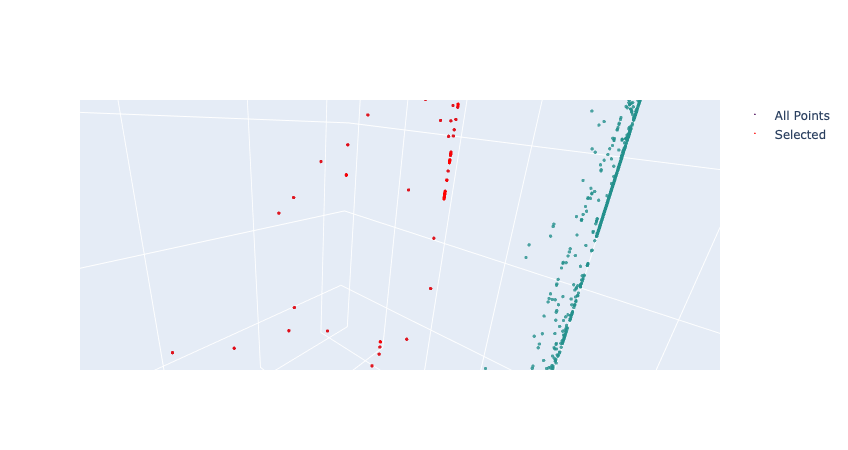

In [17]:
everything = [item for sublist in res['everything'] for item in sublist]
selected = [item for sublist in res['selected'] for item in sublist]
fig = go.Figure()

d = [l[0] for l in everything if l]
a = [l[1] for l in everything if l]
t = [l[2] for l in everything if l]
fig.add_trace(go.Scatter3d(
    x = a,
    y = t, 
    z = d,
    mode='markers',
    name='All Points',
    marker=dict(
        size=2,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )))

d2 = [l[0] for l in selected if l]
a2 = [l[1] for l in selected if l]
t2 = [l[2] for l in selected if l]
fig.add_trace(go.Scatter3d(
    x = a2,
    y = t2, 
    z = d2,
    mode='markers',
    name='Selected',
    marker=dict(
        size=2,
        color='red',                # set color to an array/list of desired values
        opacity=0.8
    )))

fig.show()
fig.write_html(file="decomp05.html")

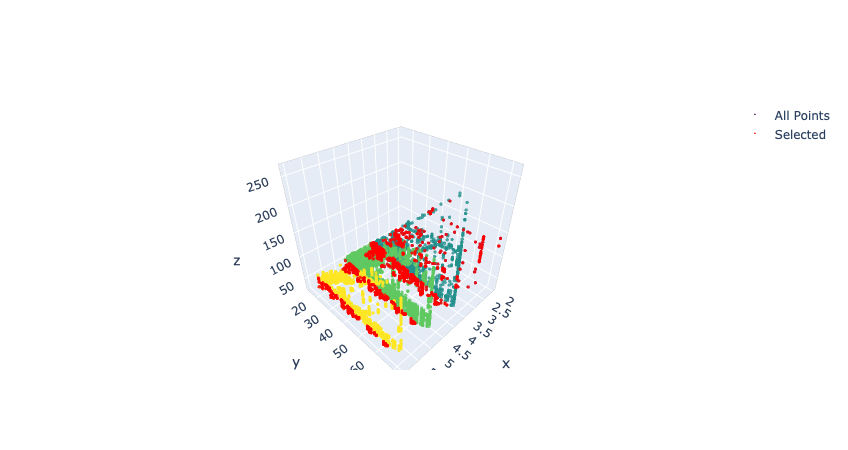

In [23]:
everything = [item for sublist in res['everything'] for item in sublist]
selected = [item for sublist in res['selected'] for item in sublist]
fig = go.Figure()

d = [l[0] for l in everything if l]
a = [l[1] for l in everything if l]
t = [l[2] for l in everything if l]
fig.add_trace(go.Scatter3d(
    x = a,
    y = t, 
    z = d,
    mode='markers',
    name='All Points',
    marker=dict(
        size=2,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )))

d2 = [l[0] for l in selected if l]
a2 = [l[1] for l in selected if l]
t2 = [l[2] for l in selected if l]
fig.add_trace(go.Scatter3d(
    x = a2,
    y = t2, 
    z = d2,
    mode='markers',
    name='Selected',
    marker=dict(
        size=2,
        color='red',                # set color to an array/list of desired values
        opacity=0.8
    )))

fig.show()
fig.write_html(file="decomp08.html")

In [7]:
results = []
weights = np.linspace(0, 1, 11)
def solve(w):
#     print(f"Starting weight: {w}")
    truncation_args = {
        'limit' : 1000,
        'method': 'decomposition',
        'w' : w
    }
    
    result = SeqSolver.sequence_search(available=ALPHA,
                                       truncation_args=truncation_args)
#     with open(f'results/exp1/variable_weight_decomp_{round(w, 2)}.pickle', 'wb') as fp:
#         pickle.dump(result, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
#     print(f"finished weight: {w}")
    return result

with Pool(processes=8) as pool:
    results = pool.map(solve, weights)

10it [01:37,  7.24s/it]                      

Finished



10it [01:39,  7.40s/it]0:00<00:03,  1.23it/s]

Finished



10it [01:41,  7.52s/it]0:00<?, ?it/s]

Finished



10it [01:41,  7.55s/it]

Finished



10it [01:41,  7.57s/it]0:00<00:02,  1.36it/s]

Finished



10it [01:42,  7.60s/it]

Finished



10it [01:42,  7.62s/it]0:00<?, ?it/s]

Finished



10it [01:42,  7.64s/it]

Finished



10it [00:34,  2.74s/it]                      

Finished



10it [00:32,  2.54s/it]

Finished



10it [00:31,  2.47s/it]

Finished


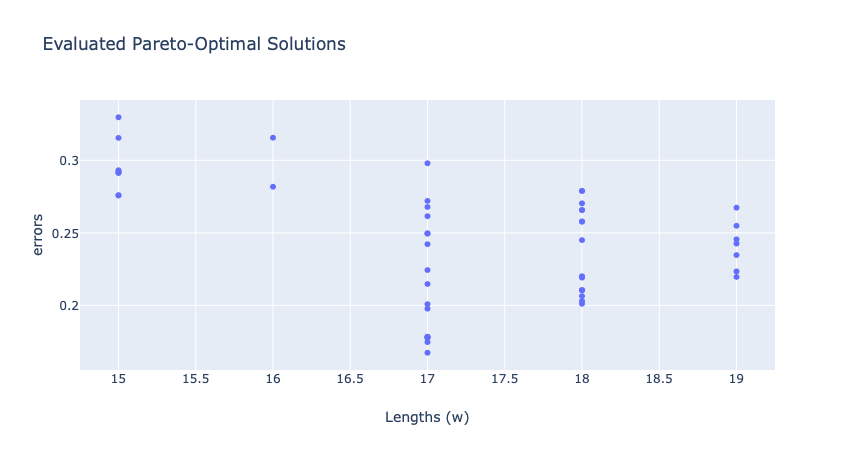

In [46]:
seq_lengths = []
errors = []

for res in results: 
    seq_lengths.append((len(res['best_dist'])-1))
    sol = res['best_dist'][1:]
    error = np.mean((np.array(sol) - PF['8'][:len(sol)])/PF['8'][:len(sol)])
    errors.append(error)

# fig = make_subplots(specs=[[{"secondary_y": True}]])
fig = go.Figure()
# fig.add_trace(go.Scatter(x=weights, y=seq_lengths, name="Sequence Length"))
fig.add_trace(go.Scatter(x=seq_lengths, y=errors, name="Average Error", mode='markers'))
barmode='stack'
# The two histograms are drawn on top of another
fig.update_layout(title='Evaluated Pareto-Optimal Solutions', 
                  xaxis_title="Lengths (w)", yaxis_title="errors")

# fig.update_yaxes(title_text="Seqence Length (Alpha)", secondary_y=False)
# fig.update_yaxes(title_text="Average Error", secondary_y=True)
                 
fig.show()

## Analyzing loss of an algorithm across Alpha

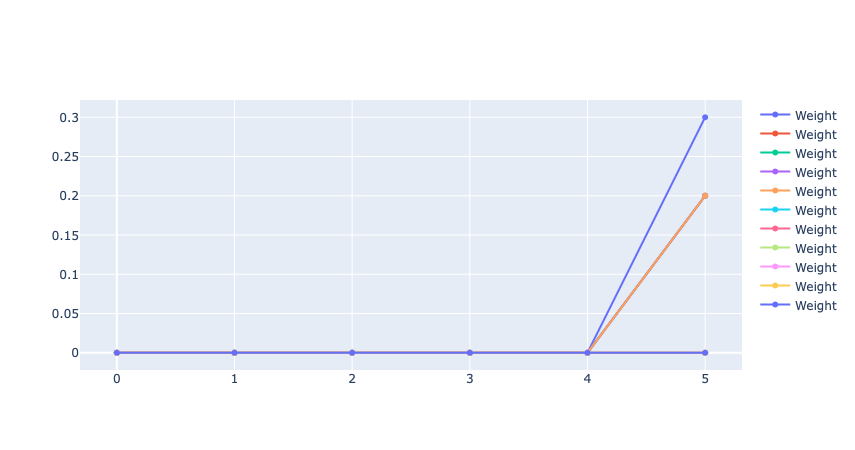

In [8]:
pf = PF[str(T)]

fig = go.Figure()

for res in results: 
    sol = res['best_dist']
    y = np.cumsum(np.around(np.array(sol), 1) - pf[:len(sol)])
    fig.add_trace(go.Scatter(x=np.arange(len(sol)), y=y, name=f"Weight"))
#     for l, sol in enumerate(res['best_dist'])
        
fig.show()